# Twitter 데이터셋의 Word Embedding 생성하기

### [(원본)](https://github.com/aws-samples/amazon-comprehend-custom-entity/blob/master/2-BlazingText-Word2Vec-Telco-tweents.ipynb)


## 소개

Word2Vec는 비지도 학습을 사용하여 큰 코퍼스 내의 단어의 밀집 벡터를 생성하는데 사용되는 인기있는 알고리즘입니다.
해당 알고리즘을 통해 생성된 결과 
벡터는 해당 단어들 사이에서 의미적 관계를 포착하여 보여지고, 이것은 감성 분석, 개체명 인식, 기계 번역과 같은 많은 자연어 처리 (NLP) 작업에서 사용됩니다. 

SageMaker는 BlazingText는 Word2Vec의 효율적인 실행 방법을 다음과 같이 제공합니다. 

- single CPU instance
- single instance with multiple GPUs - P2 or P3 instances
- multiple CPU instances (Distributed training)

이 노트북은 BlazingText에서 multiple CPU instances를 사용하여 word2vec의 분산 학습을 사용하는 방법에 대해 설명합니다. 

## 설정

다음 설정부터 시작합니다.:

- 학습과 모델 데이터를 저장하기 위해 사용할 S3 버킷과 Prefix를 정의합니다. 이것은 노트북 인스턴스와 학습, 호스팅에서 사용할 리전과 같은 위치에 있어야만 합니다. 만약 버킷을 지정하지 않으면 SagaMaker SDK는 같은 리전에서 미리 정의된 명명 규칙에 따라서 기본 버킷을 생성합니다. 
- IAM role ARN은 SageMaker가 데이터에 접근할 수 있도록 합니다. 이것은 sagemaker python SDK의 **get_execution_role** 메서드를 통해 가져올 수 있습니다.

In [50]:
import sagemaker
from sagemaker import get_execution_role
import boto3
import json

sess = sagemaker.Session()

role = get_execution_role()
print("role: {}".format(role)) # This is the role that SageMaker would use to leverage AWS resources (S3, CloudWatch) on your behalf

bucket = 'sagemaker-comprehend-seongshj'#'my-bucket' # Replace with your own bucket name if needed
print("bucket: {}".format(bucket))
prefix = 'sagemaker/DEMO-blazingtext' #Replace with the prefix under which you want to store the data if needed

role: arn:aws:iam::415373942856:role/service-role/AmazonSageMaker-ExecutionRole-20191024T194435
bucket: sagemaker-comprehend-seongshj


### 데이터 수집

단어 벡터를 학습하기 위해 kaggle의 twitter 데이터셋을 사용할 것입니다. BlazingText는 공백으로 구분된 토큰을 가진, 하나의 사전 처리된 텍스트 파일을 사용할 것이고 각 라인은 한개의 문장을 포함하고 있습니다.
 

데이터를 다운로드 후 압축이 완료되면 SageMaker에서 Traninig Job을 실행할 수 있도록 S3에 데이터를 업로드해야 합니다.  
우리는 Python SDK를 통해 위에서 설정한 버킷과 prefix위치에 파일을 업로드할 것입니다. 

In [51]:
train_channel = prefix + '/train'

sess.upload_data(path='./data/tweet_telco.csv', bucket=bucket, key_prefix=train_channel)

s3_train_data = 's3://{}/{}'.format(bucket, train_channel)

In [52]:
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)
print( "s3_output_location: {}".format(s3_output_location) )

s3_output_location: s3://sagemaker-comprehend-seongshj/sagemaker/DEMO-blazingtext/output


## Trainig 설정

이제 필요한 모든 설정이 완료되었으므로 객체 검출기를 학습시킬 준비가 되었습니다. 
우선 ``sageMaker.estimator.Estimator`` 객체를 생성해 보겠습니다. 이 Estimator로 Training job을 시작할 것입니다.


In [53]:
region_name = boto3.Session().region_name

In [54]:
container = sagemaker.amazon.amazon_estimator.get_image_uri(region_name, "blazingtext", "latest")
print('Using SageMaker BlazingText container: {} ({})'.format(container, region_name))

Using SageMaker BlazingText container: 811284229777.dkr.ecr.us-east-1.amazonaws.com/blazingtext:latest (us-east-1)


## 단어벡터 생성을 위해 BlazingText 모델 학습하기

[Word2vec](https://arxiv.org/pdf/1301.3781.pdf)과 유사하게, SageMaker BlazingText는 CPUs와 추가적인 GPU[s]를 기반의 네거티브 샘플링을 사용하여 Skip-gram 및 CBOW(Continuous Bag-Of-Words) 아키텍처를 효율적으로 구현합니다. GPU 구현은 고도로 최적화된 CUDA 커널을 사용합니다. 자세한 내용은 다음을 참조하시기 바랍니다 [*BlazingText: Scaling and Accelerating Word2Vec using Multiple GPUs*](https://dl.acm.org/citation.cfm?doid=3146347.3146354). 또한 BlazingText는 CBOW와 skip-gram 모드로 형태소 임베딩 학습을 지원합니다. 이를 통해 BlazingText가 이 [노트북](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/blazingtext_word2vec_subwords_text8/blazingtext_word2vec_subwords_text8.ipynb)예제와 같이 미등록단어(out-of-vocabulary:OOV)에서도 벡터를 생성할 수 있습니다. 



skip-gram과 CBOW 이외에도, SageMaker BlazingText는 효율적인 mini-baching과 matrix-matrix 작업을 위한 "Batch Skipgram" 모드를 지원합니다([BLAS Level 3 routines](https://software.intel.com/en-us/mkl-developer-reference-fortran-blas-level-3-routines)). 이 모드는 다중 CPU 노드에서의 분산 word2vec 학습을 가능하게 하는데, 거의 word2vec 계산의 선형적 확장으로 초당 수억개까지 처리할 수 있습니다. 자세한 내용은 [*Parallelizing Word2Vec in Shared and Distributed Memory*](https://arxiv.org/pdf/1604.04661.pdf)를 참조하시기 바랍니다. 

BlazingText는 또한 텍스트 분류를 위한 *지도학습* 모드를 지원합니다. 이것은 FastText의 Text classifier를 확장한 것으로 custom CUDA 커널을 통해 GPU가속을 활용합니다. 이 모드는 멀티코어 CPU 혹은 단일 GPU를 이용하여 몇분만에 10억개 이상 단어를 학습하고, 동시에 최신의 딥러닝 텍스트 분류 알고리즘과 동등한 성능을 얻을 수 있습니다. 자세한 내용은 [algorithm documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext.html) 혹은 [the text classification notebook](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/blazingtext_text_classification_dbpedia/blazingtext_text_classification_dbpedia.ipynb)를 참조하시기 바랍니다.

요약하면, BlazingText는 여러 유형의 인스턴에서 다음과 같은 모드를 지원합니다. 

|          Modes         	| cbow (supports subwords training) 	| skipgram (supports subwords training) 	| batch_skipgram 	| supervised |
|:----------------------:	|:----:	|:--------:	|:--------------:	| :--------------:	|
|   Single CPU instance  	|   ✔  	|     ✔    	|        ✔       	|  ✔  |
|   Single GPU instance  	|   ✔  	|     ✔    	|                	|  ✔ (Instance with 1 GPU only)  |
| Multiple CPU instances 	|      	|          	|        ✔       	|     | |


이제 두 개의 c4.2xlarge 인스턴스와 "batch_skipgram" 모드에서, *text8* 데이터셋의 단어벡터를 학습하기 위한 리소스 구성과 하이퍼파라미터를 정의하도록 하겠습니다. 


In [55]:
bt_model = sagemaker.estimator.Estimator(container,
                                         role, 
                                         train_instance_count=2, 
                                         train_instance_type='ml.c4.2xlarge',
                                         train_volume_size = 5,
                                         train_max_run = 360000,
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

하이퍼파라미터의 전체 목록은 [algorithm documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext_hyperparameters.html)를 참조하시기 바랍니다.

In [56]:
bt_model.set_hyperparameters(mode="batch_skipgram",
                             epochs=5,
                             min_count=5,
                             sampling_threshold=0.0001,
                             learning_rate=0.05,
                             window_size=5,
                             vector_dim=100,
                             negative_samples=5,
                             batch_size=11, #  = (2*window_size + 1) (Preferred. Used only if mode is batch_skipgram)
                             evaluation=True,# Perform similarity evaluation on WS-353 dataset at the end of training
                             subwords=False) # Subword embedding learning is not supported by batch_skipgram

이제 하이퍼파라미터가 설정되었으니 데이터 채널과 알고리즘 간의 연동을 위한 준비가 필요합니다. 이를 위해 데이터 채널의 `sagemaker.session.s3_input` 객체를 생성이 필요합니다. 이 객체는 간단 사전 형식으로 저장되며, 이것을 알고리즘은 사용합니다. 

In [57]:
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='text/plain', s3_data_type='S3Prefix')
data_channels = {'train': train_data}

우리는 `Estimator` 객체를 가지고 있고, 하이퍼파라미터 설정했으며 알고리즘과 연결된 데이터 채널을 가지고 있습니다. 이제 남아있는 것은 알고리즘을 학습하는 것입니다. 알고리즘 학습은 몇 단계를 거치게 됩니다. 첫번째는 `Estimator` 클래스를 생성하는 동안에 인스턴스를 프로비저닝하고 적절한 라이브러리가 설정합니다. 다음으로 데이터 채널에서 인스턴스로 데이터를 다운로드합니다. 이 작업이 완료되면 Training job이 시작됩니다. 프로비저닝과 데이터 다운로드는 어느정도 시간이 걸릴 수 있는데, 이 시간은 데이터 크기에 따라 달라집니다. 따라서 Trainig job의 로그를 받기 시작할때까지는 몇 분의 시간이 소요될 수 있습니다. Training job이 실행된 후에는, 미리 선택된 일부 검증 데이터셋에 `Spearman's Rho` 이라는 데이터 로그가 출력될 것입니다. 이 메트릭은 알고리즘 품질 측정을 위한 용도입니다. 

Training job이 완료되면 "Job complete" 메시지가 출력됩니다. 이 학습 모델은 estimator의 `output_path`로 설정되었던 S3 버킷 경로에서 찾을 수 있습니다. 

In [58]:
bt_model.fit(inputs=data_channels, logs=True)

2019-11-02 04:47:51 Starting - Starting the training job...
2019-11-02 04:47:53 Starting - Launching requested ML instances......
2019-11-02 04:48:59 Starting - Preparing the instances for training...
2019-11-02 04:49:45 Downloading - Downloading input data...
2019-11-02 04:50:17 Training - Training image download completed. Training in progress..Arguments: train
Found 10.2.219.91 for host algo-1
Found 10.2.230.165 for host algo-2
Arguments: train
Found 10.2.219.91 for host algo-1
Found 10.2.230.165 for host algo-2
[11/02/2019 04:50:29 WARNING 140359429703488] Loggers have already been setup.
[11/02/2019 04:50:29 WARNING 140359429703488] Loggers have already been setup.
[11/02/2019 04:50:29 INFO 140359429703488] nvidia-smi took: 0.0252251625061 secs to identify 0 gpus
[11/02/2019 04:50:29 INFO 140359429703488] Running distributed CPU BlazingText training using batch_skipgram on 2 hosts.
[11/02/2019 04:50:29 INFO 140359429703488] Number of hosts: 2, master IP address: 10.2.219.91, host 

### 모델 시각화

이제 학습된 모델에서 단어 벡터를 다운로드하고 [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) 플롯을 사용하여 시각화하도록 하겠습니다. 

In [59]:
s3 = boto3.resource('s3')

key = bt_model.model_data[bt_model.model_data.find("/", 5)+1:]
s3.Bucket(bucket).download_file(key, 'model.tar.gz')

`model.tar.gz` 의 압축을 풀고 `vectors.txt` 파일을 확인합니다.

In [60]:
!tar -xvzf model.tar.gz

eval.json
vectors.bin
vectors.txt


하이퍼파라미터의 "evaluation"를 "true"를 설정했으면 모델 아티펙트안에 "eval.json"이 존재합니다. 

학습모델의 품질은 단어 유사성 작업을 통해 평가됩니다. 우리는 이러한 목적으로 가장 많이 사용되는 테스트 데이터셋중에 하나인 [WS-353](http://alfonseca.org/eng/research/wordsim353.html)을 사용합니다. 이것은 사람이 지정한 유사성을 기준으로 한 단어 쌍을 포함하고 있습니다. 

단어 표현은 코사인 유사성에 따라 순위를 매기고 사람의 판단과 Spearmans 순위 상관계수를 측정하여 평가됩니다. 

eval.json 내의 평가 점수를 살펴보겠습니다. text8 데이터넷에서 학습된 임베딩의 경우 0.65 이상의 점수가 좋습니다. 


이제 단어벡터의 2D 시각화를 하겠습니다.

In [61]:
import numpy as np
from sklearn.preprocessing import normalize

# Read the 400 most frequent word vectors. The vectors in the file are in descending order of frequency.
num_points = 400

first_line = True
index_to_word = []
with open("vectors.txt","r") as f:
    for line_num, line in enumerate(f):
        if first_line:
            dim = int(line.strip().split()[1])
            word_vecs = np.zeros((num_points, dim), dtype=float)
            first_line = False
            continue
        line = line.strip()
        word = line.split()[0]
        vec = word_vecs[line_num-1]
        for index, vec_val in enumerate(line.split()[1:]):
            vec[index] = float(vec_val)
        index_to_word.append(word)
        if line_num >= num_points:
            break
word_vecs = normalize(word_vecs, copy=False, return_norm=False)

In [62]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=40, n_components=2, init='pca', n_iter=10000)
two_d_embeddings = tsne.fit_transform(word_vecs[:num_points])
labels = index_to_word[:num_points]

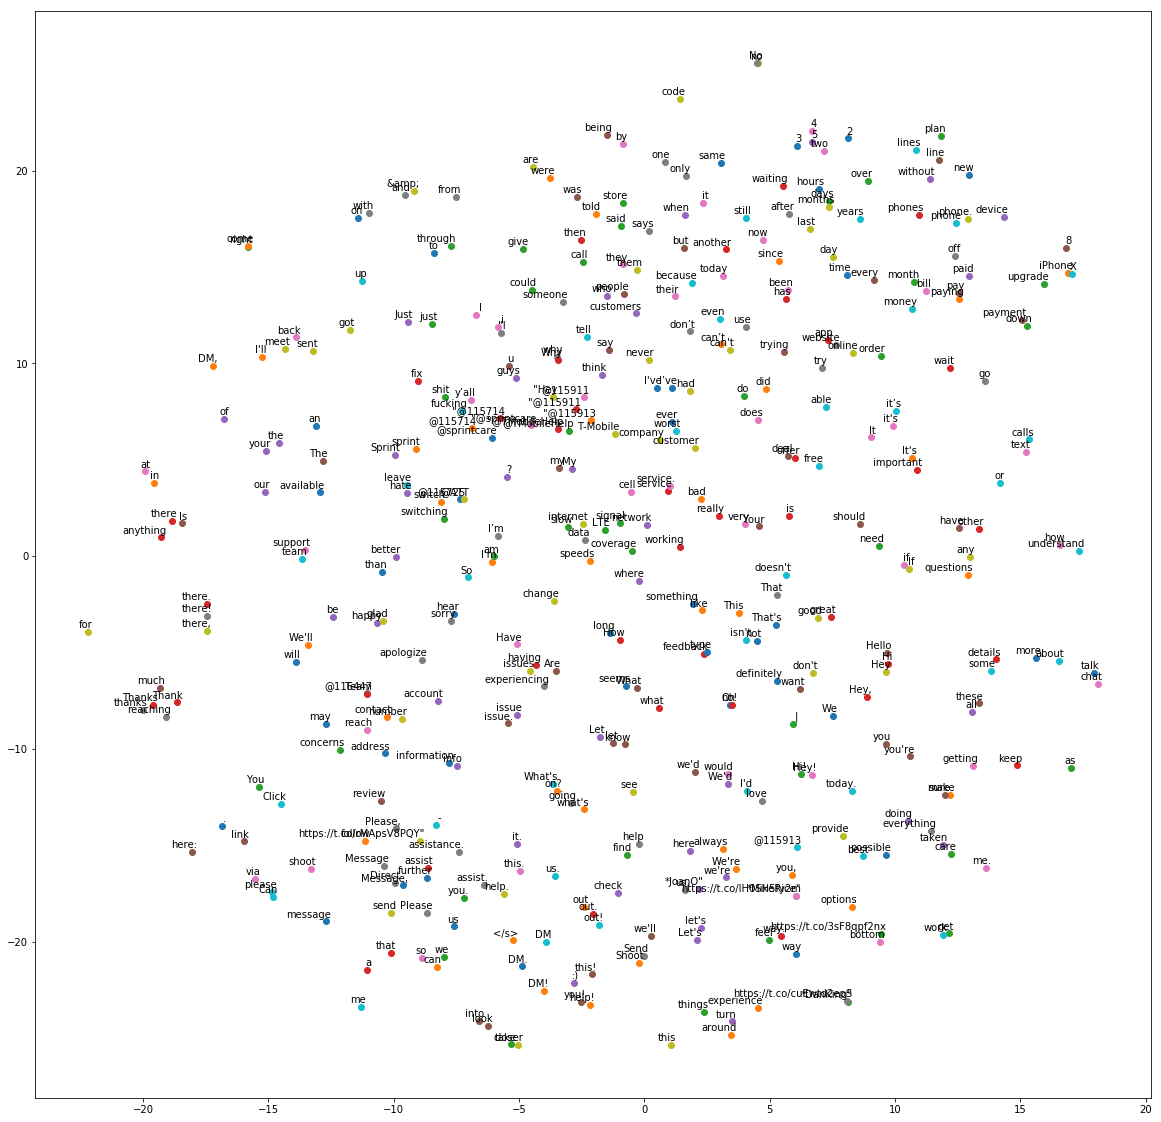

In [63]:
from matplotlib import pylab
%matplotlib inline

def plot(embeddings, labels):
    pylab.figure(figsize=(20,20))
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    pylab.show()

plot(two_d_embeddings, labels)

위의 코드를 실행하면 아래와 같은 그림이 생성될 것입니다. t-SNE와 Word2Vec 확률적인 방법으로, 코드를 실행할 때 그림이 정확하게 일치하지 않지만 
유사한 단어인 'british', 'american', 'french', 'english'는 왼쪽 바닥 부분에, 'military', 'army' and 'forces'는 바닥 부분에 가까이 있는 것을 확인할 수 있습니다.

### gensim 라이브러리를 사용하여 문맥 상 유사 단어 찾기

In [46]:
!conda install -y gensim

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.12
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



BlazingText를 사용하여 학습한 word2vec 모델을 gensim에 로드합니다. 

In [64]:
import gensim
from gensim.models import KeyedVectors
word_vectors = KeyedVectors.load_word2vec_format('vectors.txt', binary=False)

"frustrated"와 유사한 상위 20개의 키워드를 찾아보겠습니다. 이 키워드는 다른 노트북 예제인 custom negativity intent 학습 시 사용할 것입니다. 

In [65]:
result = word_vectors.most_similar(positive=['frustrated'], topn=20)
print(result)

[('upset', 0.8680824041366577), ('unhappy', 0.8672391176223755), ('Really', 0.8666666746139526), ('tweeting', 0.8636422753334045), ('bullshit.', 0.8593741655349731), ('badly', 0.8578940629959106), ('angry', 0.8562378883361816), ('surprised', 0.8556085228919983), ('disappointed.', 0.8540792465209961), ('disgusted', 0.8533158302307129), ('trapped', 0.8482762575149536), ('dissatisfied', 0.8462212085723877), ('Honestly', 0.8455758094787598), ('treated', 0.8445252776145935), ('sadly', 0.8444066047668457), ('beyond', 0.8429533243179321), ('disrespected', 0.8424504995346069), ('you’ve', 0.8417493104934692), ('handling', 0.8389210104942322), ('unhelpful', 0.8388664126396179)]


"signal"과 유사한 상위 20개의 키워드를 찾아보겠습니다. 이 키워드는 네트워크 문제나 연결과 관련된 이슈를 구분하는 데 사용할 수 있습니다. 

In [66]:
result = word_vectors.most_similar(positive=['signal'], topn=20)
print(result)

[('LTE', 0.8040101528167725), ('reception', 0.8017528057098389), ('strength', 0.7967534065246582), ('house', 0.7922930717468262), ('barely', 0.7824732065200806), ('bar', 0.7788028717041016), ('lte', 0.7750356197357178), ('signal?', 0.7688648700714111), ('4g', 0.766219973564148), ('bars.', 0.7652508020401001), ('bars', 0.7598063945770264), ('LTE.', 0.7592743635177612), ('inside', 0.7513078451156616), ('3G', 0.7507922649383545), ('Atlanta', 0.7484906911849976), ('house.', 0.7442910671234131), ('LTE,', 0.7417029142379761), ('anywhere', 0.7383332252502441), ('rarely', 0.7368378639221191), ('spotty', 0.735224723815918)]


In [27]:
"@115911 LISTEN!!! I’m getting extremely frustrated with y’all customer service. I qualify for best available pricing so I want it! | @129830 I'm all about getting what I deserve too, so I get how you feel. Send us a DM and we'll take a look at your options! *WhitneyJ"

"@115911 LISTEN!!! I’m getting extremely frustrated with y’all customer service. I qualify for best available pricing so I want it! | @129830 I'm all about getting what I deserve too, so I get how you feel. Send us a DM and we'll take a look at your options! *WhitneyJ"

In [28]:
"Life hack: don't sign up with @115714 because they are terrible. No signal in the middle of @116147? Never happened with @115725 | @128383 Please send us a Direct Message, so that we can further assist you. --OC"

"Life hack: don't sign up with @115714 because they are terrible. No signal in the middle of @116147? Never happened with @115725 | @128383 Please send us a Direct Message, so that we can further assist you. --OC"